In [1]:
%matplotlib notebook
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
from mpl_toolkits.axes_grid1 import make_axes_locatable
from hepmc import *

Can't find Sherpa installation, skipping ee_qq.


In [2]:
density = densities.Gaussian(2, scale=1)
momentum_dist = densities.Gaussian(2, scale=1)
nuts = hamiltonian.NUTSUpdate(density, momentum_dist, lambda x : True)

In [3]:
# build_tree function that returns all steps
def build_tree(q, p, u, v, j, step_size, q0, p0, Emax):
    if j == 0:
        #trajectory = [q0]
        trajectory = []
        q_prime, p_prime = nuts.simulate_custom(q, p, 1, v*step_size)
        dE = nuts.target_density.pdf(q_prime)/nuts.p_dist.pdf(p_prime)
        dE0 = nuts.target_density.pdf(q0)/nuts.p_dist.pdf(p0)
        C_prime = []
        if u <= dE:
            C_prime.append([q_prime, p_prime])
        
        s_prime = (u < Emax*dE)
        trajectory.append(q_prime)
        return (q_prime, p_prime, q_prime, p_prime, C_prime, s_prime, trajectory)
    
    else:
        (q_minus, p_minus, q_plus, p_plus, C_prime, s_prime, trajectory) = build_tree(q, p, u, v, j-1, step_size, q0, p0, Emax)
        
        if v == -1:
            (q_minus, p_minus, _, _, C_2prime, s_2prime, trajectory_prime) = build_tree(q_minus, p_minus, u, v, j-1, step_size, q0, p0, Emax)
            #trajectory = trajectory_prime[::-1] + trajectory
                
        else:
            (_, _, q_plus, p_plus, C_2prime, s_2prime, trajectory_prime) = build_tree(q_plus, p_plus, u, v, j-1, step_size, q0, p0, Emax)
            #trajectory = trajectory + trajectory_prime
        
        trajectory += trajectory_prime
        
        dq = q_plus - q_minus
        s_prime = (s_2prime*(np.dot(dq, p_minus) >= 0)*(np.dot(dq, p_plus) >= 0))
        C_prime += C_2prime
        
        return (q_minus, p_minus, q_plus, p_plus, C_prime, s_prime, trajectory)

In [4]:
nuts.step_size = .17
trajectory = []

# build the tree manually for one iteration
q0 = np.array([-.8, -.5])
trajectory.append([q0])
p0 = nuts.p_dist.proposal()
u = np.random.uniform(0, density.pdf(q0)/nuts.p_dist.pdf(p0))
q_minus, q_plus, p_minus, p_plus, q = q0, q0, p0, p0, q0
j, s = 0, 1
C = [[q0, p0]]

while s == 1:
    v = np.random.choice([-1, 1])
    if v == -1:
        print('backward')
        (q_minus, p_minus, _, _, C_prime, s_prime, trajectory_prime) = build_tree(q_minus, p_minus, u, v, j, nuts.step_size, q, p0, nuts.Emax)
        trajectory.insert(0, trajectory_prime[::-1])
    
    else:
        print('forward')
        (_, _, q_plus, p_plus, C_prime, s_prime, trajectory_prime) = build_tree(q_plus, p_plus, u, v, j, nuts.step_size, q, p0, nuts.Emax)
        trajectory.append(trajectory_prime)
    
    if s_prime == 1:
        C += C_prime
        
    dq = q_plus - q_minus
    s = s_prime * (np.dot(dq, p_minus) >= 0) * (np.dot(dq, p_plus) >= 0)
    j = j+1

backward
forward
forward
forward
forward


In [5]:
x = np.linspace(-1.5, 1.5, 100)
y = np.linspace(-1.5, 1.5, 100)
f = np.empty((100, 100))
for i, x_i in enumerate(x):
    for j, y_j in enumerate(y):
        f[j, i] = density.pdf([x_i, y_j])

<IPython.core.display.Javascript object>


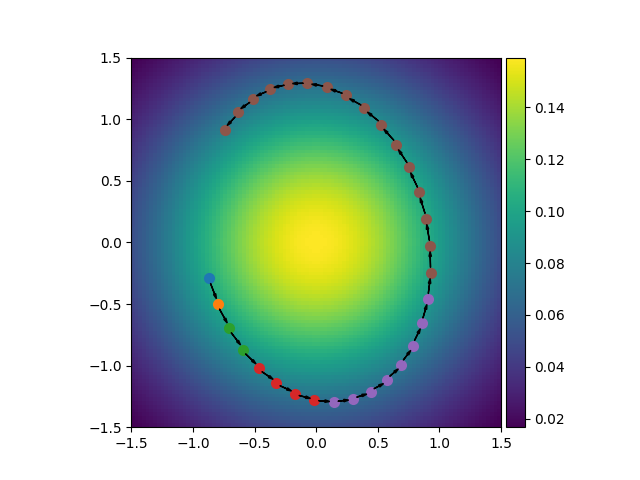

In [6]:
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')

im = ax.imshow(f, extent=[-1.5, 1.5, -1.5, 1.5], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax)

full_trajectory = [[], []]

marker_radius = 4. # points (1 point = fig.dpi/72 pixels)
marker_size = (2*marker_radius)**2
for path in trajectory:
    x = [q[0] for q in path]
    y = [q[1] for q in path]
    full_trajectory[0] = full_trajectory[0] + x
    full_trajectory[1] = full_trajectory[1] + y
    ax.scatter(x, y, s=marker_size, linewidth=0)

x = np.array(full_trajectory[0])
y = np.array(full_trajectory[1])

inv = ax.transData.inverted()
for x1, x2, y1, y2 in zip(x[1:], x[:-1], y[1:], y[:-1]):
    dx = x1-x2
    dy = y1-y2
    angle = np.arctan2(dy, dx)
    offset_pixel = marker_radius*fig.dpi/72*np.array([np.cos(angle), np.sin(angle)])
    offset_data = inv.transform(offset_pixel) - inv.transform((0., 0.))
    ax.arrow(x2+offset_data[0], y2+offset_data[1], dx-2*offset_data[0], dy-2*offset_data[1], 
         shape='full', color='k', length_includes_head=True, head_length=.04, head_width=.02)

plt.savefig('nuts_trajectory_gauss.pdf', bbox_inches='tight', pad_inches = 0, dpi = 200)

<IPython.core.display.Javascript object>


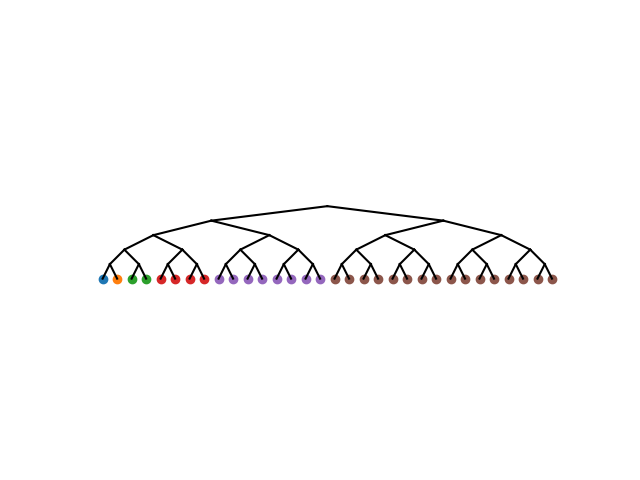

In [7]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')

full_trajectory = [[], []]

i = 0
for path in trajectory:
    x = [q[0] for q in path]
    y = [q[1] for q in path]
    full_trajectory[0] = full_trajectory[0] + x
    full_trajectory[1] = full_trajectory[1] + y
    ax.scatter(np.arange(i, i+len(path)), len(path)*[0])
    i += len(path)

x = np.array(full_trajectory[0])
y = np.array(full_trajectory[1])

num_nodes = x.size
height = int(np.log(num_nodes)/np.log(2))
ax.set_ylim(-1, height + 1)

x_nodes = np.arange(num_nodes)
y_nodes = 0
dy = 1
for h in range(height):
    dx = (x_nodes[1]-x_nodes[0])/2
    for x1, x2 in zip(x_nodes[:-1:2], x_nodes[1::2]):
        ax.plot([x1, x1+dx], [y_nodes, y_nodes+dy], 'k-')
        ax.plot([x2, x2-dx], [y_nodes, y_nodes+dy], 'k-')
    
    x_nodes = x_nodes[::2] + dx
    y_nodes += dy

plt.savefig('nuts_tree_gauss.pdf', bbox_inches='tight', pad_inches = 0, dpi = 200)

In [8]:
np.random.seed(123456789)
density = densities.Camel(2)
nuts = hamiltonian.NUTSUpdate(density, momentum_dist, lambda x : True)

In [9]:
nuts.step_size = .036
trajectory = []

# build the tree manually for one iteration
q0 = np.array([.4, .6])
trajectory.append([q0])
p0 = nuts.p_dist.proposal()
u = np.random.uniform(0, density.pdf(q0)/nuts.p_dist.pdf(p0))
q_minus, q_plus, p_minus, p_plus, q = q0, q0, p0, p0, q0
j, s = 0, 1
C = [[q0, p0]]

while s == 1:
    v = np.random.choice([-1, 1])
    if v == -1:
        print('backward')
        (q_minus, p_minus, _, _, C_prime, s_prime, trajectory_prime) = build_tree(q_minus, p_minus, u, v, j, nuts.step_size, q, p0, nuts.Emax)
        trajectory.insert(0, trajectory_prime[::-1])
    
    else:
        print('forward')
        (_, _, q_plus, p_plus, C_prime, s_prime, trajectory_prime) = build_tree(q_plus, p_plus, u, v, j, nuts.step_size, q, p0, nuts.Emax)
        trajectory.append(trajectory_prime)

    if s_prime == 1:
        C += C_prime
        
    dq = q_plus - q_minus
    s = s_prime * (np.dot(dq, p_minus) >= 0) * (np.dot(dq, p_plus) >= 0)
    j = j+1

backward
forward
backward
backward


In [10]:
x = np.linspace(0, 1, 100)
y = np.linspace(0, 1, 100)
for i, x_i in enumerate(x):
    for j, y_j in enumerate(y):
        f[j, i] = density.pdf([x_i, y_j])

<IPython.core.display.Javascript object>


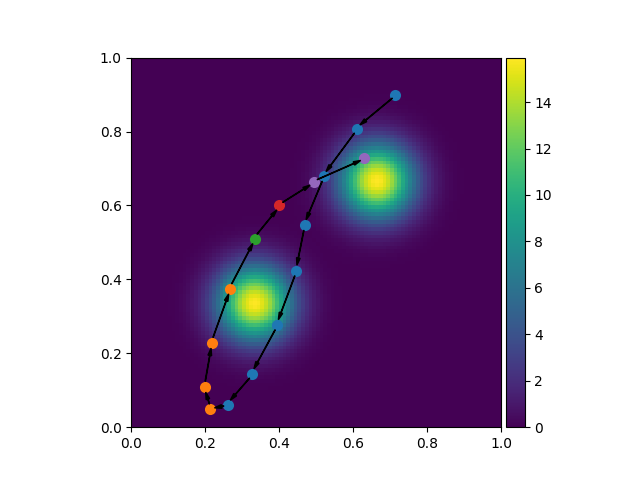

In [11]:
fig, ax = plt.subplots(dpi=100)
ax.set_aspect('equal')

im = ax.imshow(f, extent=[0, 1, 0, 1], origin='lower')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(im, cax)

full_trajectory = [[], []]

marker_radius = 4. # points (1 point = fig.dpi/72 pixels)
marker_size = (2*marker_radius)**2
for path in trajectory:
    x = [q[0] for q in path]
    y = [q[1] for q in path]
    full_trajectory[0] = full_trajectory[0] + x
    full_trajectory[1] = full_trajectory[1] + y
    ax.scatter(x, y, s=marker_size, linewidth=0)

x = np.array(full_trajectory[0])
y = np.array(full_trajectory[1])

inv = ax.transData.inverted()
for x1, x2, y1, y2 in zip(x[1:], x[:-1], y[1:], y[:-1]):
    dx = x1-x2
    dy = y1-y2
    angle = np.arctan2(dy, dx)
    offset_pixel = marker_radius*fig.dpi/72*np.array([np.cos(angle), np.sin(angle)])
    offset_data = inv.transform(offset_pixel) - inv.transform((0., 0.))
    ax.arrow(x2+offset_data[0], y2+offset_data[1], dx-2*offset_data[0], dy-2*offset_data[1], 
         shape='full', color='k', length_includes_head=True, head_length=.02, head_width=.01)

plt.savefig('nuts_trajectory_camel.pdf', bbox_inches='tight', pad_inches = 0, dpi = 200)

<IPython.core.display.Javascript object>


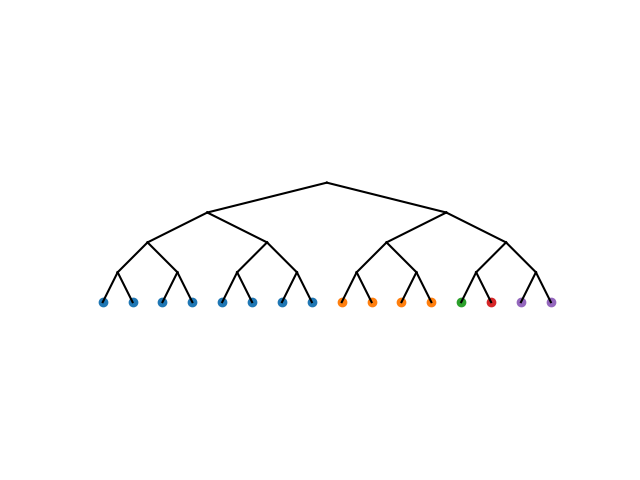

In [12]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.axis('off')

full_trajectory = [[], []]

i = 0
for path in trajectory:
    x = [q[0] for q in path]
    y = [q[1] for q in path]
    full_trajectory[0] = full_trajectory[0] + x
    full_trajectory[1] = full_trajectory[1] + y
    ax.scatter(np.arange(i, i+len(path)), len(path)*[0])
    i += len(path)

x = np.array(full_trajectory[0])
y = np.array(full_trajectory[1])

num_nodes = x.size
height = int(np.log(num_nodes)/np.log(2))
ax.set_ylim(-1, height + 1)

x_nodes = np.arange(num_nodes)
y_nodes = 0
dy = 1
for h in range(height):
    dx = (x_nodes[1]-x_nodes[0])/2
    for x1, x2 in zip(x_nodes[:-1:2], x_nodes[1::2]):
        ax.plot([x1, x1+dx], [y_nodes, y_nodes+dy], 'k-')
        ax.plot([x2, x2-dx], [y_nodes, y_nodes+dy], 'k-')
    
    x_nodes = x_nodes[::2] + dx
    y_nodes += dy

plt.savefig('nuts_tree_camel.pdf', bbox_inches='tight', pad_inches = 0, dpi = 200)